In [8]:
import numpy as np
from simulation import *
from math import *
import matplotlib.pyplot as plt
from IPython.display import Image
meterial = meterial_s
def print_meterial(m): 
    pass 
degree = pi/180

* 展示 poynting 矢量, 吸收功率和电场传播的计算


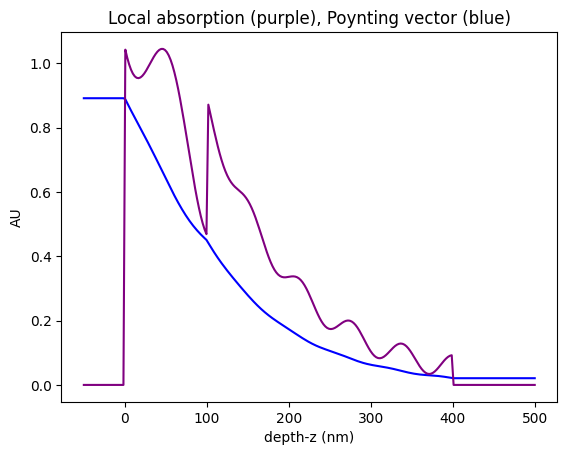

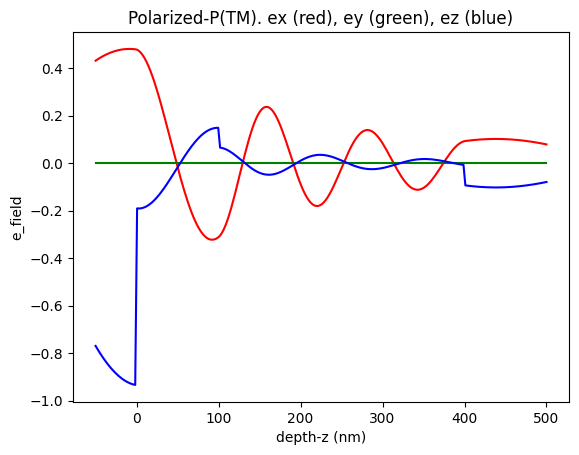

In [9]:
def c_matrix_to_np(m):
    r0, r1 = m
    a00, a01 = r0
    a10, a11 = r1
    return np.array([[a00, a01],[a10, a11]])

def decompose_tmm_multiply(tmm_list):
    np_matrix2x2 = [c_matrix_to_np(m) for m in tmm_list]
    tmm = list()
    tmm.append(np_matrix2x2[0])
    for i in range(1, len(np_matrix2x2)):
        temp = np.dot(np.linalg.inv(np_matrix2x2[i-1]), np_matrix2x2[i])
        tmm.append(temp)
    return tmm

def get_vw_list(tmm_list, interface_list):
    r, t = TMM_get_r_t_from_tmm(tmm_list[-1])
    vw = np.array([[t],[0]])
    vw_list = np.zeros((len(interface_list) + 1, 2), dtype=complex)
    vw_list[-1,:] = np.transpose(vw)
    # vw_list[0, :] = np.transpose([1, r])
    for i in range(len(vw_list)-2, -1, -1):
        M = c_matrix_to_np(interface_list[i])
        temp = np.dot(M, vw)
        vw = temp
        vw_list[i,:] = np.transpose(vw)
    assert(np.abs(1 - vw_list[0,0]) < 1e-6)
    assert(np.abs(r - vw_list[0,1]) < 1e-6)

    return vw_list

def poynting_vector_and_absorb_example(debug = False):
    air = meterial()
    air.nk = 1
    air.depth = 0

    m0 = meterial()
    m0.nk = 2.2+0.2j
    m0.depth = 100
    
    m1 = meterial()
    m1.depth = 300
    m1.nk = 3.3+0.3j
    meterials = [air, m0, m1, air]

    th_0 = pi/4
    lam_vac = 400.0
    dir = TMM_propagate_direction(meterials, th_0)
    # print(f"dir={dir}, th_0={th_0}")
    tmm_list1 = TMM_interface_transfer_matrix_with_thickness_without_multiply_p(meterials, dir, lam_vac)

    if debug:
        tmm_list = TMM_interface_transfer_matrix_with_thickness_p(meterials, dir, lam_vac)
        max_error = np.max(np.array([np.max(np.abs(a-c_matrix_to_np(b))) for a, b in zip(decompose_tmm_multiply(tmm_list), tmm_list1)]))
        print(f"    debug-1 max_error = {max_error}")
        assert(1e-6 > max_error)
        tmm_list2 = tmm_list
    tmm_list = TMM_apply_multilayer_effect(tmm_list1)
    if debug:
        max_error = np.max(np.array([np.max(np.abs(c_matrix_to_np(a)-c_matrix_to_np(b))) for a, b in zip(tmm_list, tmm_list2)]))
        print(f"    debug-2 max_error = {max_error}")
        assert(1e-6 > max_error)

    vw_list = get_vw_list(tmm_list, tmm_list1)
    if debug: print(f"vw_list={vw_list}")

    ds = np.linspace(-50, 500, num=240)
    poyn = []
    absor = []
    ex = []
    ey = []
    ez = []
    structure_start_pos = TMM_get_structure_pos(meterials)
    if debug: print(f"structure_start_pos={structure_start_pos}")

    for d in ds:
        layer_id, depth_in_layer = TMM_find_in_structure(structure_start_pos, d)
        phase_matrix = TMM_propagate_matrix_to_target_depth(lam_vac, dir, meterials, layer_id, depth_in_layer)
        Eforward, Ebackward = np.dot(c_matrix_to_np(phase_matrix), vw_list[layer_id])
        # print(f"layer_id={layer_id}, depth_in_layer={depth_in_layer}")
        # print(f"phase_matrix={c_matrix_to_np(phase_matrix)[1][1]}\nvw_list[layer_id]={vw_list[layer_id]}\n\n")
        # print(f"Ef={Eforward}, Eb={Ebackward}\n\n")

        absorb = TMM_get_absorbed_energy_density_p(Eforward, Ebackward, lam_vac, dir, meterials, layer_id)
        ponyting = TMM_get_poynting_vector_p(Eforward, Ebackward, dir[layer_id], meterials[layer_id].nk, dir[0], meterials[0].nk)
        e_field = TMM_get_e_field_p(Eforward, Ebackward, dir[layer_id])
        if debug:
            print(f"absor={absorb}")
            print(f"pony={ponyting}")
            print(f"e_field={e_field}")

        poyn.append(ponyting)
        absor.append(absorb)
        x,y,z = e_field
        ex.append(x.real)
        ey.append(y.real)
        ez.append(z.real)
    # # convert data to numpy arrays for easy scaling in the plot
    poyn = np.array(poyn)
    absor = np.array(absor)
    print_meterial(meterials)
    plt.figure()
    plt.plot(ds, poyn, 'blue', ds, 200*absor, 'purple')
    plt.xlabel('depth-z (nm)')
    plt.ylabel('AU')
    plt.title('Local absorption (purple), Poynting vector (blue)')
    plt.show()

    plt.figure()
    plt.plot(ds,  np.array(ex), 'red', ds, np.array(ey), 'green', ds, np.array(ez), 'blue')
    plt.xlabel('depth-z (nm)')
    plt.ylabel('e_field')
    plt.title('Polarized-P(TM). ex (red), ey (green), ez (blue)')
    plt.show()
print("* 展示 poynting 矢量, 吸收功率和电场传播的计算")
poynting_vector_and_absorb_example()

* 对比正入射和斜入射, 在不同波长下, 非偏光的反射率


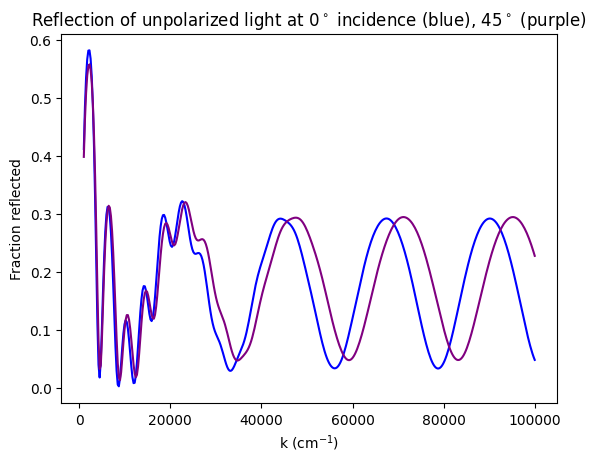

In [10]:
def reflection_example():
    air = meterial()
    air.nk = 1

    m0 = meterial()
    m0.nk = 2.2
    m0.depth = 100

    m1 = meterial()
    m1.nk = 3.3+0.3j
    m1.depth = 300

    meterials = [air, m0, m1, air]
    ks = np.linspace(0.0001, .01, num=400)
    Rnorm = []
    R45 = []
    for k in ks:
        dir = TMM_propagate_direction(meterials, 0)
        # 正入射s/p结果相同，只用算一遍
        r,t = TMM_get_r_t_power_from_tmm_s(
            TMM_interface_transfer_matrix_with_thickness_s(meterials, dir, 1/k)[-1],
            meterials[0].nk, dir[0], meterials[-1].nk, dir[-1]
        )
        Rnorm.append(r)
        
        dir = TMM_propagate_direction(meterials, 45 * degree)
        r,t = TMM_get_unpolarized_r_t_power_from_tmm(
            TMM_interface_transfer_matrix_with_thickness_s(meterials, dir, 1/k)[-1],
            TMM_interface_transfer_matrix_with_thickness_p(meterials, dir, 1/k)[-1],
            meterials[0].nk, dir[0], meterials[-1].nk, dir[-1]
        )
        R45.append(r)
    kcm = ks * 1e7
    plt.figure()
    plt.plot(kcm, Rnorm, 'blue', kcm, R45, 'purple')
    plt.xlabel(r'k (cm$^{-1}$)')
    plt.ylabel('Fraction reflected')
    plt.title(r'Reflection of unpolarized light at 0$^\circ$ incidence (blue), '
              r'45$^\circ$ (purple)')
    plt.show()

print("* 对比正入射和斜入射, 在不同波长下, 非偏光的反射率")
reflection_example()

* 计算在不同波长下(正入射), S偏振的透过率


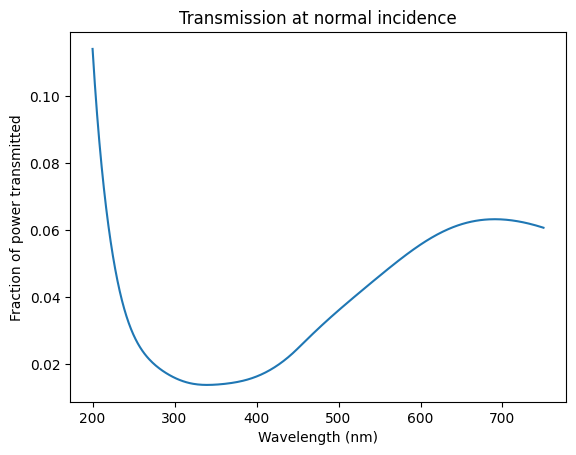

In [11]:
from scipy.interpolate import interp1d

def transmission_sample(depth = 300, 
                        material_nk_data = np.array([[200, 2.1+0.1j],
                              [300, 2.4+0.3j],
                              [400, 2.3+0.4j],
                              [500, 2.2+0.4j],
                              [750, 2.2+0.5j]]),
                        incidence_angle = 0 * pi, 
                        lambda_list = np.linspace(200, 750, 400)
    ):
    material_nk_fn = interp1d(material_nk_data[:,0].real,
                              material_nk_data[:,1], kind='quadratic')
    
    air = meterial()
    air.nk = 1
    air.depth = 0

    m0 = meterial()
    m0.depth = depth
    
    T_list = []
    for lambda_vac in lambda_list:
        m0.nk = complex(material_nk_fn(lambda_vac))
        meterials = [air, m0, air]
        dir = TMM_propagate_direction(meterials, incidence_angle)
        r,t = TMM_get_r_t_power_from_tmm_s(
            TMM_interface_transfer_matrix_with_thickness_s(meterials, dir, lambda_vac)[-1],
            meterials[0].nk, dir[0], meterials[-1].nk, dir[-1]
        )
        T_list.append(t)
    plt.figure()
    plt.plot(lambda_list, T_list)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Fraction of power transmitted')
    plt.title('Transmission at normal incidence')
    plt.show()
print("* 计算在不同波长下(正入射), S偏振的透过率")
transmission_sample()

* 计算在不同厚度下, 椭圆偏振的振幅比和相位差


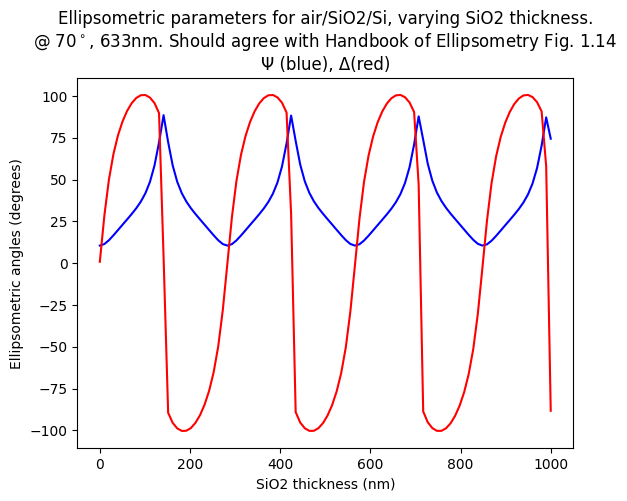

In [12]:
def ellips(meterials, crao,wavelength):
    dir = TMM_propagate_direction(meterials, crao)
    rs, ts = TMM_get_r_t_from_tmm(TMM_interface_transfer_matrix_with_thickness_s(meterials, dir, wavelength)[-1])
    rp, tp = TMM_get_r_t_from_tmm(TMM_interface_transfer_matrix_with_thickness_p(meterials, dir, wavelength)[-1])
    return np.arctan(abs(rp/rs)), np.angle(-rp/rs)

def ellipsometric_sample():
    """
    Here is a calculation of the psi and Delta parameters measured in
    ellipsometry. This reproduces Fig. 1.14 in Handbook of Ellipsometry by
    Tompkins, 2005.
    """
    
    air = meterial()
    air.nk = 1

    sio2 = meterial()
    sio2.nk = 1.46
    
    si = meterial()
    si.nk = 3.87+0.02j

    ds = np.linspace(0, 1000, num=100) #in nm
    psis = []
    Deltas = []
    degree = pi/180

    for d in ds:
        sio2.depth = d
        psi, delta_phase = ellips([air, sio2, si], 70*degree, 633) #in nm
        psis.append(psi/degree) # angle in degrees
        Deltas.append(delta_phase/degree) # angle in degrees
    plt.figure()
    plt.plot(ds, psis, 'blue', ds, Deltas, 'red')
    plt.xlabel('SiO2 thickness (nm)')
    plt.ylabel('Ellipsometric angles (degrees)')
    plt.title('Ellipsometric parameters for air/SiO2/Si, varying '
            'SiO2 thickness.\n'
            r'@ 70$^\circ$, 633nm. '
            'Should agree with Handbook of Ellipsometry Fig. 1.14\n'
            '\u03A8 (blue), \u0394(red)')
    plt.show()

print("* 计算在不同厚度下, 椭圆偏振的振幅比和相位差")
ellipsometric_sample()

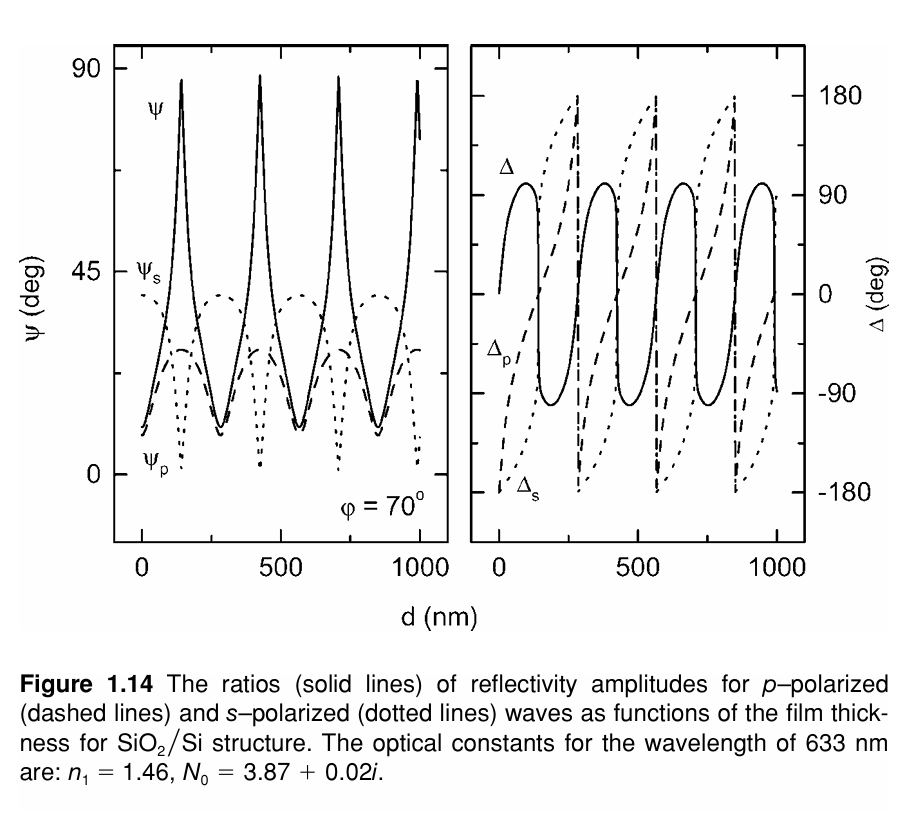

In [15]:
Image(filename='../resource/tmm/ellipsometric_sample.png')

*  SPR现象早在1902年由Wood发现，他观察到当电磁波射向金属表面时，
其反射光谱会产生异常，表现为在特定角度下反射光强度明显下降，
光谱上出现明显的暗带。而且金属膜表面折射率的变大会导致暗带位置发生变化

wavelength=633nm


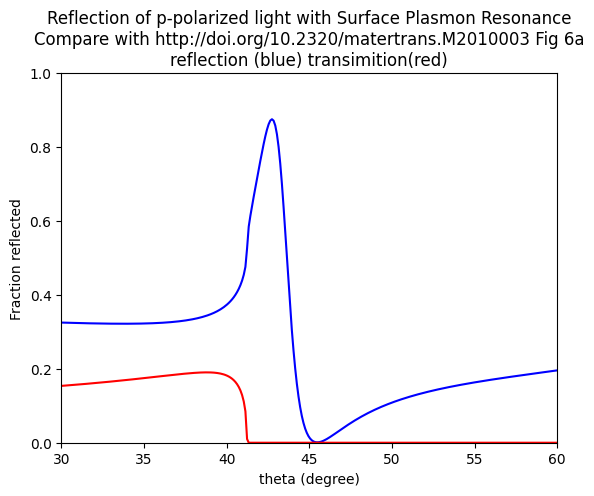

In [ ]:
def reflection_of_surface_plasmon_resonance():

    bk7 = meterial()
    bk7.nk = 1.517

    chromium = meterial()
    chromium.nk = 3.719+4.362j
    chromium.depth = 5

    gold = meterial()
    gold.nk = 0.130+3.162j
    gold.depth = 30

    air = meterial()
    air.nk = 1

    meterials = [bk7, chromium, gold, air]
    print_meterial(meterials)

    lam_vac = 633
    print(f"wavelength={lam_vac}nm")
    theta_list = np.linspace(30*degree, 60*degree, num=300)
    Rp = []
    Tp=[]
    for theta in theta_list:
        dir = TMM_propagate_direction(meterials, theta)
        dir[0] = TMM_apply_surface_plasmon_resonance_effect(meterials[0].nk, dir[0])
        dir[-1] = TMM_apply_surface_plasmon_resonance_effect(meterials[-1].nk, dir[-1])
        rp, tp = TMM_get_r_t_power_from_tmm_p(TMM_interface_transfer_matrix_with_thickness_p(meterials, dir, lam_vac)[-1],
            meterials[0].nk, dir[0], meterials[-1].nk, dir[-1]
        )
        Rp.append(rp)
        Tp.append(tp)
    plt.figure()
    plt.plot(theta_list/degree, Rp, 'blue', theta_list/degree, Tp, 'red')
    plt.xlabel('theta (degree)')
    plt.ylabel('Fraction reflected')
    plt.xlim(30, 60)
    plt.ylim(0, 1)
    plt.title('Reflection of p-polarized light with Surface Plasmon Resonance\n'
              'Compare with http://doi.org/10.2320/matertrans.M2010003 Fig 6a\n'
              'reflection (blue) transimition(red)'
    )
    plt.show()


print(
    "*  SPR现象早在1902年由Wood发现，他观察到当电磁波射向金属表面时，\n"
    "其反射光谱会产生异常，表现为在特定角度下反射光强度明显下降，\n"
    "光谱上出现明显的暗带。而且金属膜表面折射率的变大会导致暗带位置发生变化\n"
)
reflection_of_surface_plasmon_resonance()

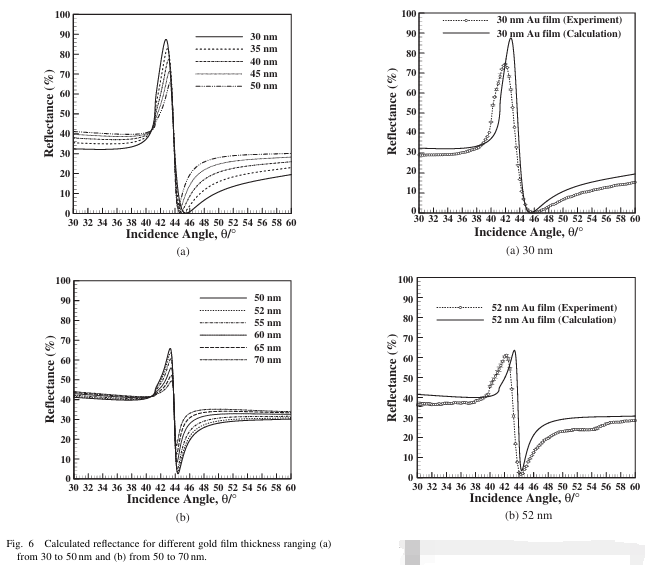

In [16]:
Image(filename='../resource/tmm/reflection_of_surface_plasmon_resonance.png')